In [1]:
# Take shots for creating dataset
import random
import os
from gym import spaces
import time
import json
import pybullet as p
import numpy as np
import pybullet_data
import pdb
import distutils.dir_util
import glob
from pkg_resources import parse_version
import gym
from bullet.tm700 import tm700
from bullet.tm700_possensor_Gym import tm700_possensor_gym
from bullet.tm700_rgbd_Gym_generate_simulated_data import tm700_rgbd_gym_generate_simulated_data
import time


shot_width = 720
shot_height = 720
num_dataset = 10

if __name__ == '__main__':
    p.connect(p.GUI)
    tm = tm700_rgbd_gym_generate_simulated_data(width=shot_width, height=shot_height)
    for ite in range(num_dataset):
        tm.reset()
    p.disconnect()


current_dir=/home/luben/Simulator/bullet
Category: {'table': 1, 'lamp': 2, 'guitar': 3, 'mug': 4, 'knife': 5}


In [2]:
# Create COCO dataset
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
import numpy as np
import os
import json

dataset_path = 'datasets/simulated_data'
    
# Create category
shapenet_dataset_folder_name = 'shapenet_subset'
IDX2NAME = os.listdir(shapenet_dataset_folder_name)
NAME2IDX = {}
for idx,class_name in enumerate(IDX2NAME):
    NAME2IDX[class_name] = idx+1
IDX2NAME.insert(0,'background')
print('NAME2IDX:',NAME2IDX)
print('IDX2NAME:',IDX2NAME)


new_data_categories = []
print('\nCreate category:')
for i in tqdm(range(len(NAME2IDX))):   
    cat_id  = i + 1
    dic = {}
    dic['supercategory'] = 'shapenet'
    dic['id'] = cat_id
    dic['name'] = IDX2NAME[i]
    new_data_categories.append(dic)
    
# Transform np array into jpg
np_im_dir = Path(os.path.join(dataset_path,'np_img'))
print('Transform np array into jpg:')
for _n in tqdm(range(1, num_dataset+1)):
    n_6d = "%06d" % _n
    np_im_path = list(np_im_dir.glob('image_'+str(_n)+'.npy'))[0]
    im = np.load(np_im_path)
    im_save_dir = Path(os.path.join(dataset_path,'images/simulated2020'))
    cv2.imwrite(str(im_save_dir/ Path(n_6d+'.jpg')), im[:, :, ::-1])


# Create images
new_data_images = []
print('Create images:')
for i in tqdm(range(1, num_dataset+1)):
    n_6d = "%06d" % i
    dic = {}
    dic['license'] = 1
    dic['file_name'] = n_6d + '.jpg'
    dic['coco_url'] = ''
    dic['height'] = shot_height
    dic['width'] = shot_width
    dic['date_captured'] = '2020-08-10 22:00:00'
    dic['flickr_url'] = ''
    dic['id'] = i  # id of 1.jpg is 1
    new_data_images.append(dic)
    
# Create annotations
new_data_annotations = []
cnt = 0
print('Create annotations:')
for i in tqdm(range(1, num_dataset+1)):
    img_id = i
    img_path_6d = "%06d" % i
    dets = np.load(os.path.join(dataset_path,'np_anno/annotation_') + str(i) + '.npy')
    for j in range(dets.shape[0]):
        box_info = dets[j]
        dic = {}
        dic['segmentation'] = [[878.87]]
        dic['area'] = 8.7 
        dic['iscrowd'] = 0
        dic['image_id'] = img_id
        dic['bbox'] = [box_info[0], box_info[1], box_info[2], box_info[3]]
        dic['category_id'] = int(box_info[4])
        cnt += 1
        dic['id'] = cnt 
        new_data_annotations.append(dic)
        
# Create COCO dataset
new_dict = {}
new_data_info = {'description': 'Robotic Dataset'}
new_data_licenses = []

new_dict['info'] = new_data_info
new_dict['images'] = new_data_images
new_dict['licenses'] = new_data_licenses
new_dict['annotations'] = new_data_annotations
new_dict['categories'] = new_data_categories

dump_path = os.path.join(dataset_path,'annotations/train.json')
with open(dump_path, 'w') as f:
    json.dump(new_dict, f)

# COCO api test
from pycocotools.coco import COCO
_COCO = COCO(dump_path)



NAME2IDX: {'table': 1, 'lamp': 2, 'guitar': 3, 'mug': 4, 'knife': 5}
IDX2NAME: ['background', 'table', 'lamp', 'guitar', 'mug', 'knife']

Create category:



Transform np array into jpg:



Create images:



Create annotations:



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of images: 10
Number of annotations: 31
NUmber of categories: 5


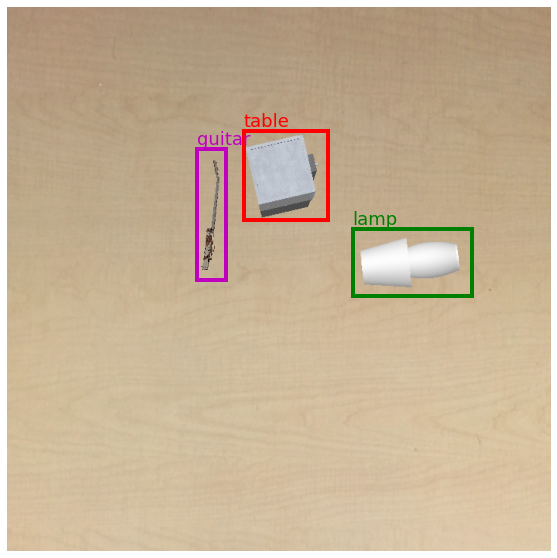

In [4]:
# Example
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import random

filePath = os.path.join(dataset_path,'annotations/train.json')
coco = COCO(filePath)
numOfImgs = len(coco.imgs)
print('\nNumber of images:',numOfImgs)
print('Number of annotations:',len(coco.anns))
print('NUmber of categories:',len(coco.cats))


#cats = coco.loadCats(coco.getCatIds())
#nms=[cat['name'] for cat in cats]
#print('COCO categories: {}'.format(','.join(nms)))
#catIds = coco.getCatIds(catNms=['table'])
#imgIds = coco.getImgIds(catIds=catIds)
#imgIds = coco.getImgIds(imgIds = [1])
#print(imgIds)

random.seed()
imgIds = coco.getImgIds(imgIds = [random.randint(1,numOfImgs)])
img = coco.loadImgs(imgIds[0])[0]
#print(img)
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
#print(anns)

im = mpimg.imread(os.path.join(dataset_path,'images/simulated2020/') + img['file_name'])  
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_selected = random.sample(colors, k=len(anns))
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(im)
currentAxis=plt.gca()
for idx,ann in enumerate(anns):
    color = color_selected[idx]
    bbox = anns[idx]['bbox']
    class_name = IDX2NAME[anns[idx]['category_id']]
    rect=patches.Rectangle((bbox[0], bbox[1]),bbox[2],bbox[3],linewidth=4,edgecolor= color,facecolor='none')
    currentAxis.add_patch(rect)
    plt.text(bbox[0], bbox[1]-5, class_name, fontsize=18,color = color)
plt.show()